In [1]:
# Ethereum Transaction Graph Analysis
# Load required libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [2]:
# Load the Ethereum transaction data
df = pd.read_csv('ethereum_medium3.csv')

print("Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
# print("\nFirst few rows:")
# print(df.head())

# print(f"\nDate range: {df['transaction_day'].min()} to {df['transaction_day'].max()}")
# print(f"Root node: {df['root_node'].iloc[0]}")
# print(f"Unique addresses: {len(set(df['from_address'].unique()) | set(df['to_address'].unique()))}")


Data loaded successfully!
Dataset shape: (38834, 7)
Columns: ['hash', 'block_number', 'from_address', 'to_address', 'value', 'transaction_day', 'graph_node']


In [3]:
# Construct the directed graph with edge features
G = nx.DiGraph()

# Add all unique addresses as nodes
all_addresses = set(df['from_address'].unique()) | set(df['to_address'].unique())
G.add_nodes_from(all_addresses)

print(f"Added {len(all_addresses)} nodes to the graph")

# Convert 'value' column to numeric (in case it's stored as strings)
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# Group transactions by edge (from_address, to_address)
edge_data = df.groupby(['from_address', 'to_address']).agg({
    'value': ['count', 'sum', 'mean'],
    'hash': 'count'
}).reset_index()

# Flatten column names
edge_data.columns = ['from_address', 'to_address', 'transaction_count', 'total_value', 'avg_value', 'hash_count']

# Add edges with attributes
for _, row in edge_data.iterrows():
    G.add_edge(
        row['from_address'], 
        row['to_address'],
        transaction_count=row['transaction_count'],
        total_value=row['total_value'],
        avg_value=row['avg_value']
    )

print(f"Added {G.number_of_edges()} edges to the graph")
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Added 32208 nodes to the graph
Added 33137 edges to the graph
Graph has 32208 nodes and 33137 edges


=== DEGREE DISTRIBUTION ===
In-degree distribution:
  Min: 0, Max: 1375, Mean: 1.03, Median: 1.0

Out-degree distribution:
  Min: 0, Max: 1893, Mean: 1.03, Median: 0.0

Nodes with out-degree > 2: 219 (0.68%)


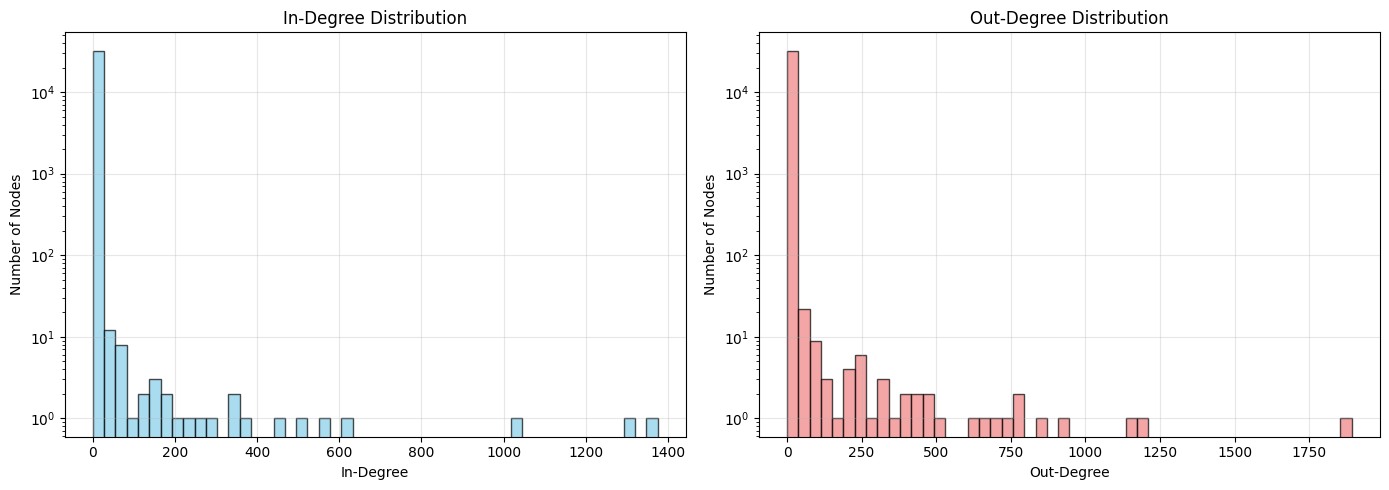

In [39]:
# 1. Degree Distribution Analysis
in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]

# Count nodes with >2 out-degree neighbors
nodes_with_out_degree_gt2 = sum(1 for d in out_degrees if d > 2)

print("=== DEGREE DISTRIBUTION ===")
print(f"In-degree distribution:")
print(f"  Min: {min(in_degrees)}, Max: {max(in_degrees)}, Mean: {np.mean(in_degrees):.2f}, Median: {np.median(in_degrees):.1f}")
print(f"\nOut-degree distribution:")
print(f"  Min: {min(out_degrees)}, Max: {max(out_degrees)}, Mean: {np.mean(out_degrees):.2f}, Median: {np.median(out_degrees):.1f}")
print(f"\nNodes with out-degree > 2: {nodes_with_out_degree_gt2} ({100*nodes_with_out_degree_gt2/len(G.nodes()):.2f}%)")

# Visualize degree distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(in_degrees, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_xlabel('In-Degree')
axes[0].set_ylabel('Number of Nodes')
axes[0].set_title('In-Degree Distribution')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

axes[1].hist(out_degrees, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Out-Degree')
axes[1].set_ylabel('Number of Nodes')
axes[1].set_title('Out-Degree Distribution')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
in_degree = np.array(in_degrees)
out_degree = np.array(out_degrees)

new_test_in_degree = in_degree[in_degree == 1]
print(len(new_test_in_degree))

new_test_out_degree = out_degree[out_degree == 1]
print(len(new_test_out_degree))

10763
20573


Randomly selected node: 0x0145e20dc2759977a01a02f52d8b6aa25daa6549


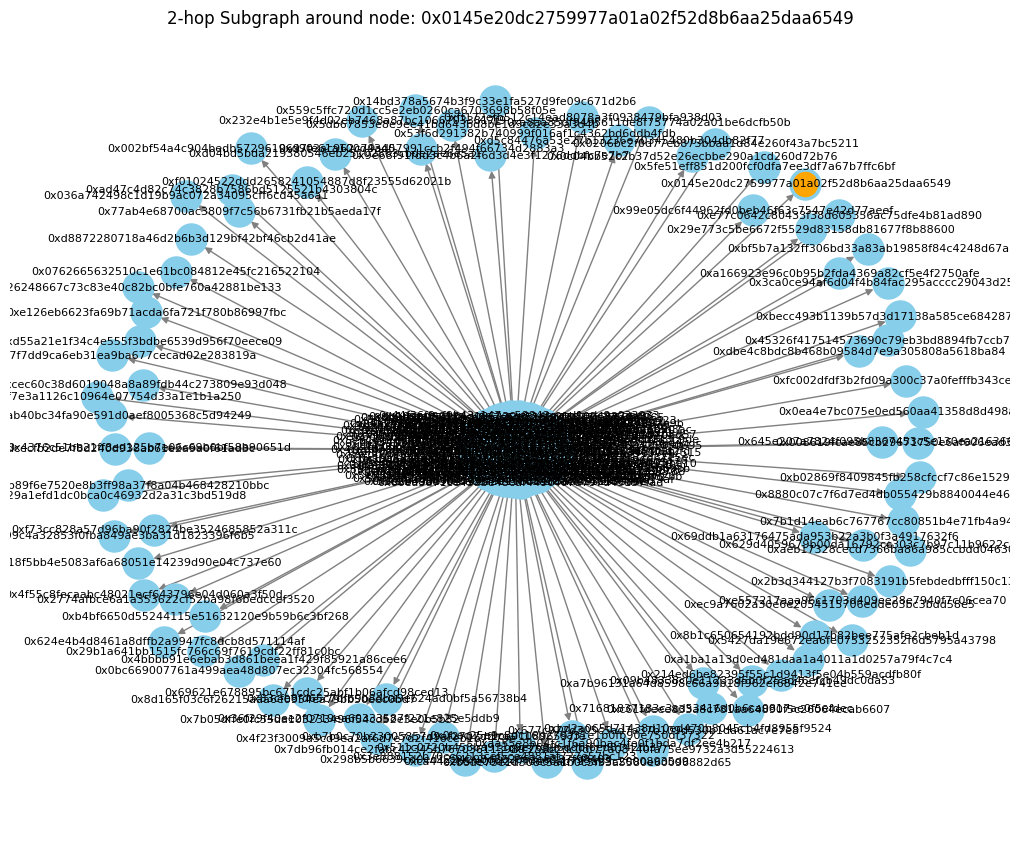

In [40]:
import random
import networkx as nx

# Choose a random node
random_node = random.choice(list(G.nodes()))
print(f"Randomly selected node: {random_node}")

# Get the set of nodes within 2 hops from the chosen node (including itself)
nodes_2hop = set([random_node])
# 1-hop neighbors (successors + predecessors)
neighbors_1 = set(G.successors(random_node)).union(set(G.predecessors(random_node)))
nodes_2hop.update(neighbors_1)
# 2-hop neighbors
for n in neighbors_1:
    nodes_2hop.update(set(G.successors(n)))
    nodes_2hop.update(set(G.predecessors(n)))

# Induced subgraph
subG = G.subgraph(nodes_2hop)

# Visualize the 2-hop subgraph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subG, seed=42)
nx.draw(subG, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray', font_size=8)
nx.draw_networkx_nodes(subG, pos, nodelist=[random_node], node_color='orange', label="Start Node")
plt.title(f"2-hop Subgraph around node: {random_node}")
plt.show()


Found 412 edges connecting nodes with degree > 2

Selected edge: 0x1e4a3213... ↔ 0x64775a80...
Node 1 degree: 4
Node 2 degree: 3

Subgraph contains 7 nodes and 7 edges


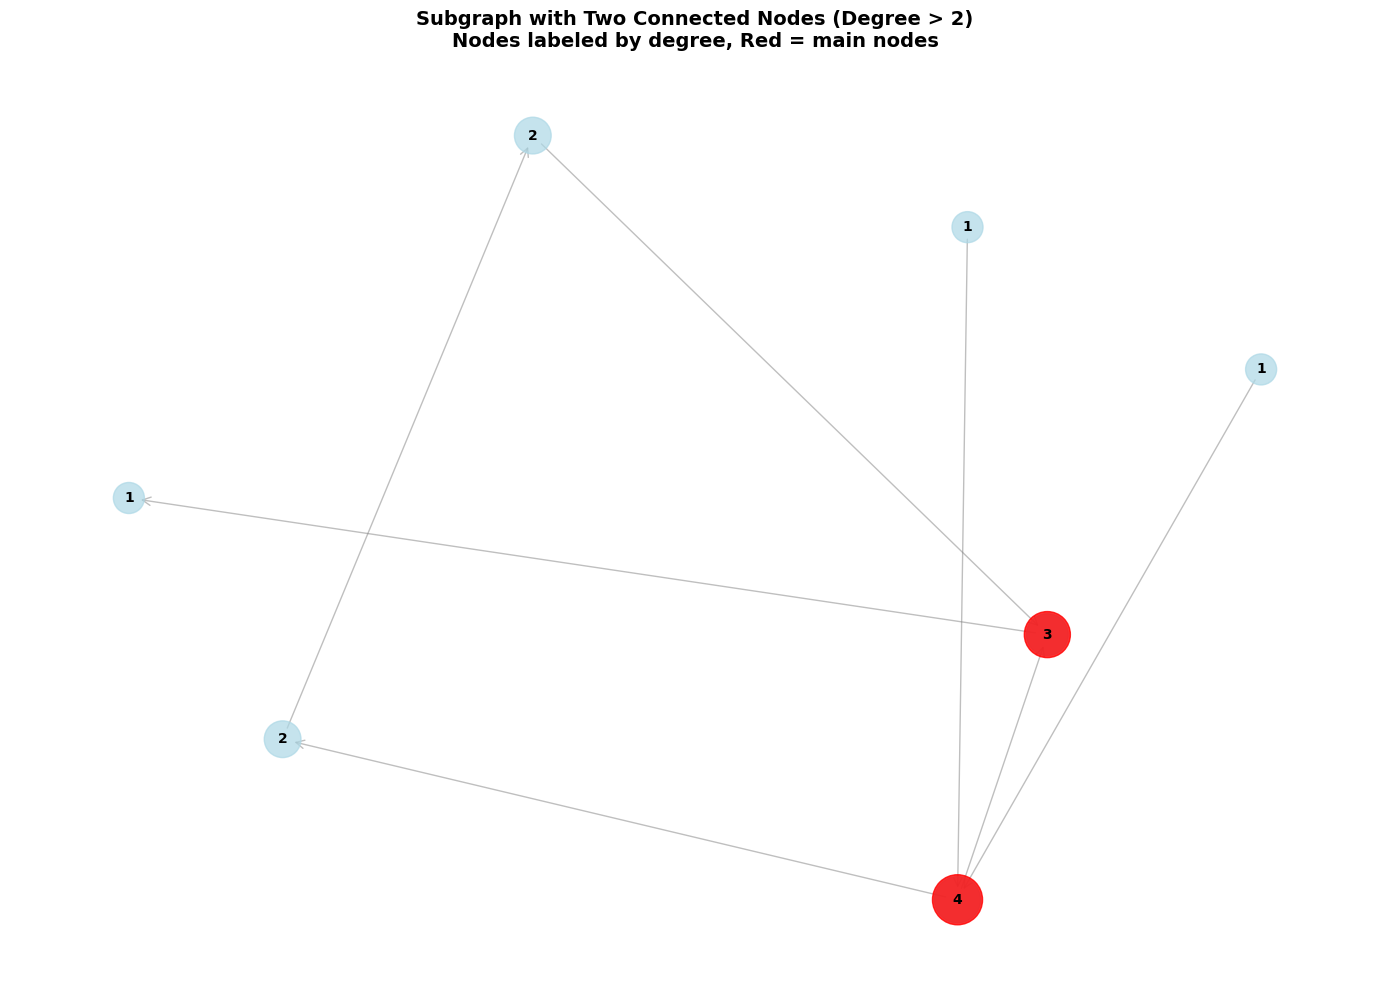

In [4]:
# Find and visualize subgraph with two connected nodes, each with degree > 2
# Find edges where both endpoints have degree > 2
degree_dict = dict(G.degree())

# Find all edges where both nodes have degree > 2
candidate_edges = []
for u, v in G.edges():
    if degree_dict[u] > 2 and degree_dict[v] > 2:
        candidate_edges.append((u, v))

print(f"Found {len(candidate_edges)} edges connecting nodes with degree > 2")

if len(candidate_edges) > 0:
    # Pick the first candidate edge
    node1, node2 = candidate_edges[0]
    print(f"\nSelected edge: {node1[:10]}... ↔ {node2[:10]}...")
    print(f"Node 1 degree: {degree_dict[node1]}")
    print(f"Node 2 degree: {degree_dict[node2]}")
    
    # Create subgraph including these two nodes and their neighbors
    subgraph_nodes = set([node1, node2])
    # Add all neighbors of both nodes
    subgraph_nodes.update(G.successors(node1))
    subgraph_nodes.update(G.predecessors(node1))
    subgraph_nodes.update(G.successors(node2))
    subgraph_nodes.update(G.predecessors(node2))
    
    subgraph = G.subgraph(subgraph_nodes)
    
    print(f"\nSubgraph contains {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")
    
    # Visualize the subgraph
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(subgraph, k=2, iterations=50, seed=42)
    
    # Node sizes based on degree
    node_sizes = [subgraph.degree(node) * 200 + 300 for node in subgraph.nodes()]
    
    # Draw nodes
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, 
                           node_color='lightblue', alpha=0.7)
    
    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, alpha=0.5, edge_color='gray', 
                           arrows=True, arrowsize=15, arrowstyle='->')
    
    # Create labels with degrees (not addresses)
    labels = {node: str(subgraph.degree(node)) for node in subgraph.nodes()}
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=10, font_weight='bold')
    
    # Highlight the two main nodes
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[node1, node2],
                           node_size=[subgraph.degree(node1) * 200 + 500, 
                                     subgraph.degree(node2) * 200 + 500],
                           node_color='red', alpha=0.8)
    
    plt.title('Subgraph with Two Connected Nodes (Degree > 2)\nNodes labeled by degree, Red = main nodes', 
              fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No edges found connecting nodes with degree > 2")


Number of subgraphs with two connected nodes (degree > 2): 412
Number of subgraphs with two connected nodes (degree > 1): 2481
Selected nodes for subgraph visualization:
  node1: 0x4976a4a02f38326660d17bf34b431dc6e2eb2327
  node2: 0xbf3e5854ffd6c8f75be921f98156a63caa585452


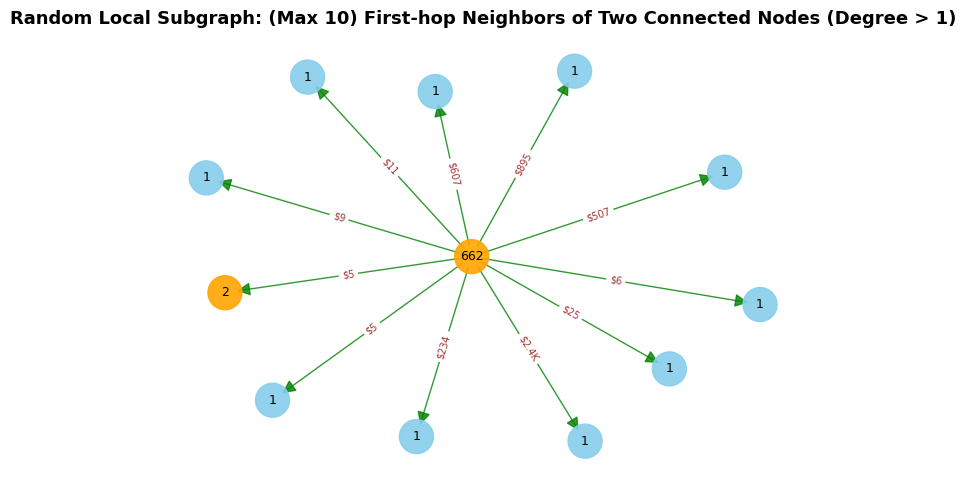

In [33]:
import random

# Current ETH price in USD
ETH_PRICE_USD = 3040
WEI_PRICE_ETH = 10**(-18)

# Count subgraphs (edge pairs) with two connected nodes both having degree > 2
edges_deg_gt_2 = [
    (u, v) for u, v in G.edges()
    if G.degree(u) > 2 and G.degree(v) > 2
]
num_subgraphs_deg_gt_2 = len(edges_deg_gt_2)
print(f"Number of subgraphs with two connected nodes (degree > 2): {num_subgraphs_deg_gt_2}")

# Count subgraphs (edge pairs) with two connected nodes both having degree > 1
edges_deg_gt_1 = [
    (u, v) for u, v in G.edges()
    if G.degree(u) > 1 and G.degree(v) > 1
]
num_subgraphs_deg_gt_1 = len(edges_deg_gt_1)
print(f"Number of subgraphs with two connected nodes (degree > 1): {num_subgraphs_deg_gt_1}")

# Display a subgraph: randomly select one eligible edge, show neighbors
if edges_deg_gt_1:
    node1, node2 = random.choice(edges_deg_gt_1)  # Pick a random eligible edge each run

    # Print the names (hashes) of the two selected nodes
    print(f"Selected nodes for subgraph visualization:\n  node1: {node1}\n  node2: {node2}")

    # Get up to 10 first-hop neighbors of each node (excluding the other node)
    neighbors_1 = set(list(n for n in G.neighbors(node1) if n != node2)[:10])
    neighbors_2 = set(list(n for n in G.neighbors(node2) if n != node1)[:10])
    local_nodes = {node1, node2} | neighbors_1 | neighbors_2
    subgraph = G.subgraph(local_nodes)
    pos = nx.spring_layout(subgraph, seed=42)
    
    plt.figure(figsize=(7, 5))
    
    default_size = 600
    # Highlight main two nodes
    node_colors = []
    for node in subgraph.nodes():
        if node in (node1, node2):
            node_colors.append('orange')
        else:
            node_colors.append('skyblue')
    nx.draw_networkx_nodes(subgraph, pos, node_size=default_size, node_color=node_colors, alpha=0.9)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.8, edge_color='green', arrows=True, arrowsize=20)
    
    # Label nodes with their degree in the full graph
    labels = {node: f"{G.degree(node)}" for node in subgraph.nodes()}
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=9)
    
    # Add edge weight labels (total value in USD)
    edge_labels = {}
    for u, v in subgraph.edges():
        if subgraph.has_edge(u, v):
            edge_data = subgraph[u][v]
            total_value_eth = edge_data.get('total_value', 0)
            total_value_usd = total_value_eth * ETH_PRICE_USD * WEI_PRICE_ETH
            # Format: show USD value, rounded to 2 decimal places
            if total_value_usd >= 1000:
                edge_labels[(u, v)] = f"${total_value_usd/1000:.1f}K"
            else:
                edge_labels[(u, v)] = f"${total_value_usd:.0f}"
    
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels, font_size=7, font_color='darkred', alpha=0.8)
    
    plt.title('Random Local Subgraph: (Max 10) First-hop Neighbors of Two Connected Nodes (Degree > 1)', fontsize=13, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No edges found connecting nodes with degree > 1")
